### LICENSE PLATE OBJECT DETECTION

Based on https://huggingface.co/datasets/keremberke/license-plate-object-detection

In [1]:
# Install dependencies and libreries
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate migrate.exe run script.py
troubleshoot troubleshoot.exe trust-script.py trust.exe

Jupyter command `jupyter-nbextension` not found.


In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoFeatureExtractor
from datasets import load_dataset, Image
import torchvision.transforms as transform
# For data augmentation
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, ColorJitter, ToTensor


/home/benja/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:

data_set = load_dataset( "keremberke/license-plate-object-detection", name="full")

In [6]:
# Test dataset features
ds_test = data_set['test']
ds_test.features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['license_plate'], id=None)}, length=-1, id=None)}

In [7]:
# Train Dataset features
ds_train=data_set['train']
ds_train.features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['license_plate'], id=None)}, length=-1, id=None)}

### Preprocessing data

In [8]:
#List of images
images = ds_train[:]['image']
#images

In [9]:
# Showing the three first images
images[:3]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>]

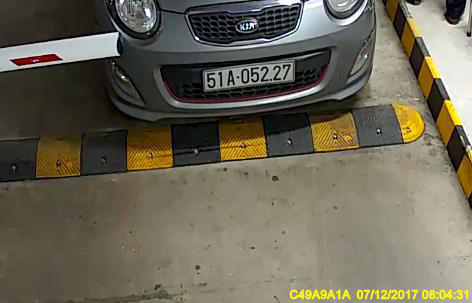

In [10]:
images[0]

In [11]:
# Data augmentation
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

tranform_ds = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(64, 64)),
    torchvision.transforms.RandomRotation(degrees=90), torchvision.transforms.RandomPerspective(0.8),
    torchvision.transforms.RandomGrayscale(0.5),
    torchvision.transforms.ToTensor()])

In [12]:
list_image_transformed = []
for images_tr in images:
    img_tr=tranform_ds(images_tr)
    list_image_transformed.append(img_tr)

In [13]:
# Checking the data augmentation applied
img =list_image_transformed[0]

In [14]:
# Transform the tensor to image
transform_img = transform.ToPILImage()

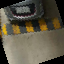

In [15]:
image = transform_img(img)
image.show()